In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys, os
sys.path.append(os.path.abspath(".."))

from src.features import make_time_feats, integrity_flags

In [90]:
# 1. Load data
df = pd.read_csv("../data/fraud_mock.csv")
df.head()

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,acc910286,170136.0,160296.36,acc298089,0.0,0.0,0,0
1,1,PAYMENT,1864.28,acc6597009,21249.0,19384.72,acc8726693,0.0,0.0,0,0
2,1,TRANSFER,181.00,acc1796908,181.0,0.00,acc4938640,0.0,0.0,1,0
3,1,CASH_OUT,181.00,acc4182296,181.0,0.00,acc1221153,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,acc7841596,41554.0,29885.86,acc5599142,0.0,0.0,0,0


In [91]:
# --- BASIC CHECKS ---
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")

print("\nData types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

print(f"\nNumber of duplicated rows: {df.duplicated().sum():,}")


Dataset shape: 6,362,620 rows × 11 columns

Data types:
time_ind              int64
transac_type         object
amount              float64
src_acc              object
src_bal             float64
src_new_bal         float64
dst_acc              object
dst_bal             float64
dst_new_bal         float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

Missing values per column:
time_ind            0
transac_type        0
amount              0
src_acc             0
src_bal             0
src_new_bal         0
dst_acc             0
dst_bal             0
dst_new_bal         0
is_fraud            0
is_flagged_fraud    0
dtype: int64

Number of duplicated rows: 0


In [92]:
# --- Understanding `is_flagged_fraud` variable ---

print(f"Flagged fraud transactions: {df['is_flagged_fraud'].sum()} rows")

flagged_not_fraud = df[(df['is_flagged_fraud'] == 1) & (df['is_fraud'] == 0)]
print(f"\nFlagged but not fraud: {len(flagged_not_fraud):,} rows")

flagged_small_amount = df[(df['is_flagged_fraud'] == 1) & (df['amount'] <= 200000)]
print(f"Flagged with amount ≤ 200,000: {len(flagged_small_amount):,} rows")

Flagged fraud transactions: 16 rows

Flagged but not fraud: 0 rows
Flagged with amount ≤ 200,000: 0 rows


Transaction type frequency:


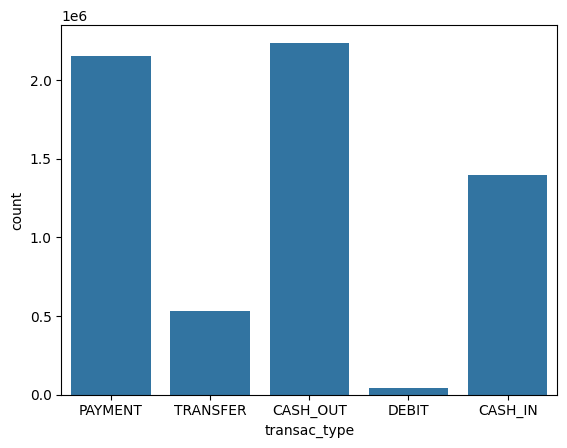


Amount distribution:


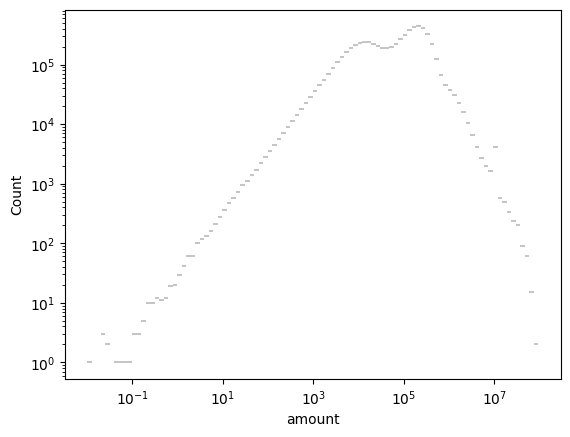

In [93]:
# 2. UNIVARIATE ANALYSIS
print('Transaction type frequency:')
sns.countplot(data=df, x='transac_type')
plt.show()

print('\nAmount distribution:')
sns.histplot(df['amount'], bins=100, log_scale=(True, True))
plt.show()

Fraud vs Non-fraud counts:
is_fraud
0    6354407
1       8213
Name: count, dtype: int64
Fraud percentage: 0.1291%


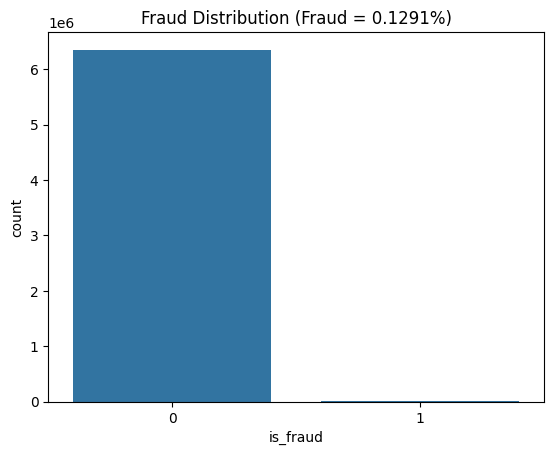

In [94]:
# Fraud vs non-fraud counts + percentage
fraud_counts = df['is_fraud'].value_counts()
fraud_pct = df['is_fraud'].mean() * 100

print("Fraud vs Non-fraud counts:")
print(fraud_counts)
print(f"Fraud percentage: {fraud_pct:.4f}%")

sns.countplot(data=df, x='is_fraud')
plt.title(f"Fraud Distribution (Fraud = {fraud_pct:.4f}%)")
plt.show()

Correlation matrix:


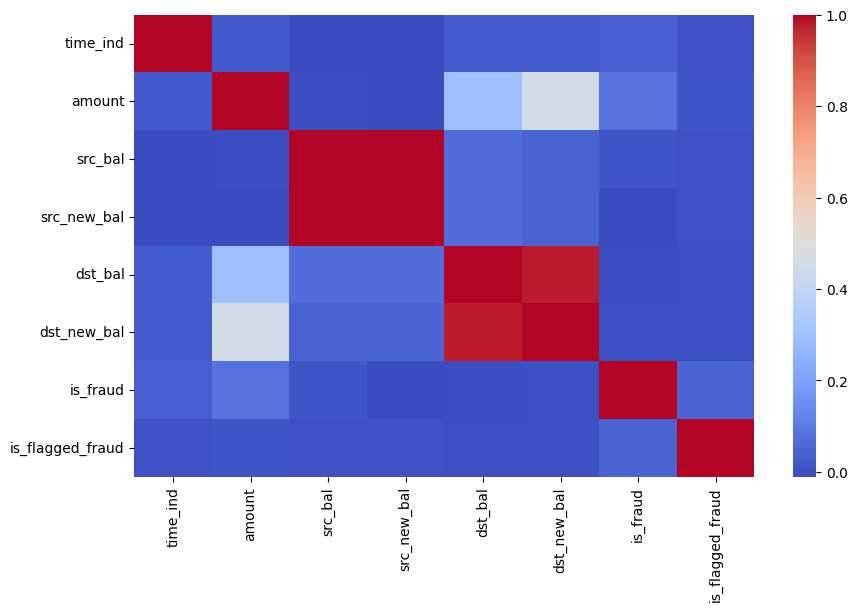


Fraud rate by transaction type:
transac_type
CASH_IN     0.000000
CASH_OUT    0.001840
DEBIT       0.000000
PAYMENT     0.000000
TRANSFER    0.007688
Name: is_fraud, dtype: float64


In [95]:
# 3. BIVARIATE
print('Correlation matrix:')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.show()

print('\nFraud rate by transaction type:')
fraud_rate = df.groupby("transac_type")["is_fraud"].mean()
print(fraud_rate)

Amount distributions (fraud vs non-fraud):


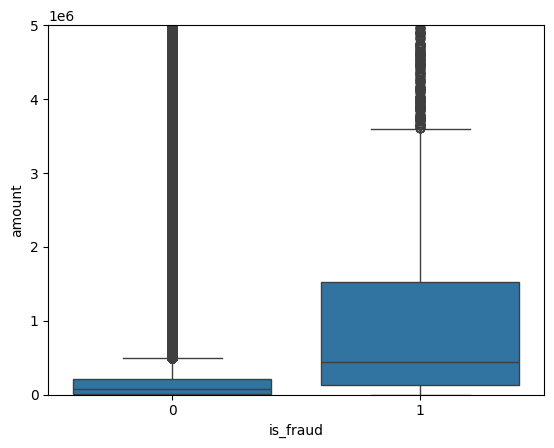

In [96]:
# Investigate relationship of `amount` and `is_fraud`
print('Amount distributions (fraud vs non-fraud):')
sns.boxplot(data=df, x="is_fraud", y="amount")
plt.ylim(0, 5e6)   # zoom in, since outliers may be huge
plt.show()

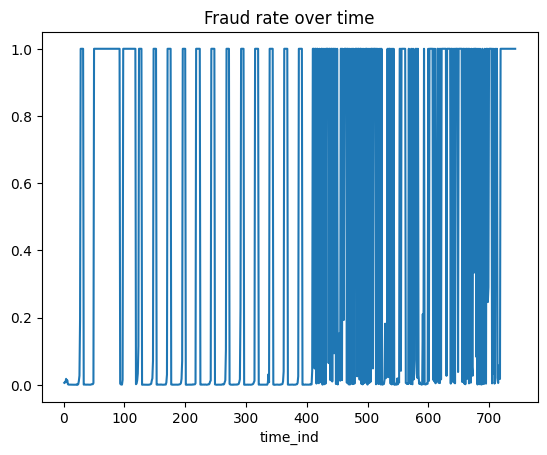

In [97]:
# 4. TIME ANALYSIS
fraud_time = df.groupby("time_ind")["is_fraud"].mean()
fraud_time.plot(title="Fraud rate over time")
plt.show()

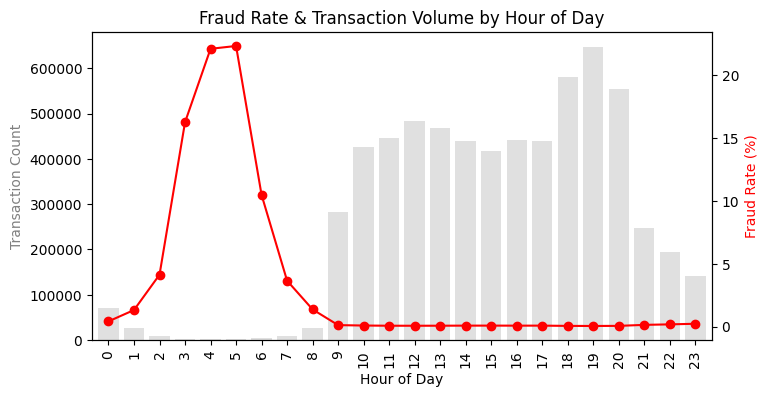

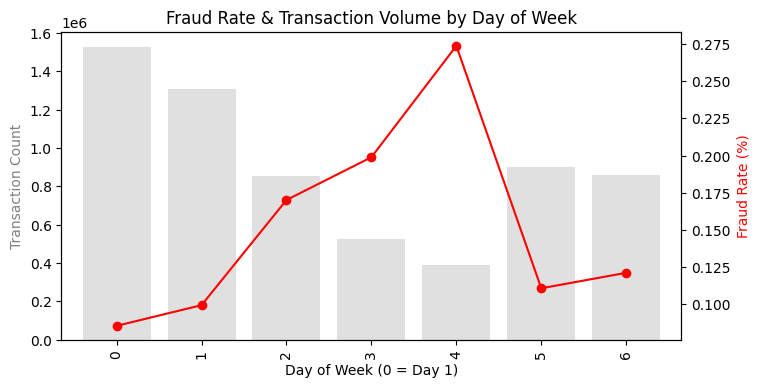

In [98]:
# --- Fraud & Transaction Rates by Time ---
# TODO: Revisit

# Derive hour of day and day of week
df = make_time_feats(df)

# --- By hour of day ---
trans_by_hour = df.groupby('hour').size()
fraud_by_hour = df.groupby('hour')['is_fraud'].mean() * 100

fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

trans_by_hour.plot(kind='bar', ax=ax1, color='lightgray', alpha=0.7, width=0.8, label='Transactions')
fraud_by_hour.plot(ax=ax2, color='red', marker='o', label='Fraud Rate (%)')

ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Transaction Count", color="gray")
ax2.set_ylabel("Fraud Rate (%)", color="red")
plt.title("Fraud Rate & Transaction Volume by Hour of Day")
plt.show()

# --- By day of week ---
trans_by_dow = df.groupby('day_of_week').size()
fraud_by_dow = df.groupby('day_of_week')['is_fraud'].mean() * 100

fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

trans_by_dow.plot(kind='bar', ax=ax1, color='lightgray', alpha=0.7, width=0.8, label='Transactions')
fraud_by_dow.plot(ax=ax2, color='red', marker='o', label='Fraud Rate (%)')

ax1.set_xlabel("Day of Week (0 = Day 1)")
ax1.set_ylabel("Transaction Count", color="gray")
ax2.set_ylabel("Fraud Rate (%)", color="red")
plt.title("Fraud Rate & Transaction Volume by Day of Week")
plt.show()


In [99]:
# 5. DATA QUALITY CHECKS

# Check negative values
negatives = (df.select_dtypes(include="number") < 0).sum()
print("Negative value counts:")
print(negatives)

Negative value counts:
time_ind            0
amount              0
src_bal             0
src_new_bal         0
dst_bal             0
dst_new_bal         0
is_fraud            0
is_flagged_fraud    0
hour                0
day_of_week         0
dtype: int64


In [ ]:
# Find inconsistencies in types where fraud occurs (CASH_OUT, TRANSFER) — EDA only
df = df[(df['transac_type'] == 'CASH_OUT') | (df['transac_type'] == 'TRANSFER')]
print(f"Transactions with possible fraud types: {df.shape[0]:,}")

df = integrity_flags(df)
print("\nInconsistency counts:")
# TODO: Make the printout more comprehensive
print(df[['flag_overdraft', 'flag_src_mismatch', 'flag_dst_mismatch', 'flag_any_inconsistency']].sum())

Transactions with possible fraud types: 2,770,409

Inconsistency counts:
flag_overdraft            2488634
flag_src_mismatch         2488785
flag_dst_mismatch          263932
flag_any_inconsistency    2513467
dtype: int64


# Key Findings from above EDA

## Characteristics
- All transactions with `is_flagged_fraud` are also correctly labeled as `is_fraud`.  
- There are only 16 flagged frauds, so they are not critical for EDA focus.  
- Some transactions have amounts less than 1 baht, which is irregular.
- `src_bal` and `src_new_bal` are highly correlated (likely redundant).  
- `dst_bal` and `dst_new_bal` are also highly correlated.  
- There are many transactions with balance mismatches (data quality concern).  

## Insights on Fraud
- Only 0.1291% of transactions are fraud (high class imbalance).  
- The variable most correlated with `is_fraud` is `amount`.  
- Fraudulent transactions occur only in `CASH_OUT` and `TRANSFER` types.  
- Fraudulent transactions are generally of higher amounts.  
- Temporal patterns:  
  - Fraud is more frequent in the later half of the timeline.  
  - Higher fraud rate between 0–8 AM (assumed).  
  - Fraud appears more concentrated on certain days of the week.  


In [16]:
# Using insights to determine types of transactions that are risky as fraud
RISK_TYPES_PATH = "../data/risk_types.json"
RISK_TYPES = {"CASH_OUT", "TRANSFER"}
with open(RISK_TYPES_PATH, "w") as f:
    json.dump(sorted(RISK_TYPES), f, indent=2)
print(
    f"Saved risk types ({', '.join(sorted(RISK_TYPES))}) to: {RISK_TYPES_PATH}")

Saved risk types (CASH_OUT, TRANSFER) to: ../data/risk_types.json


In [ ]:
# TODO: Add titles to the plots themselves